In [1]:
import random
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [2]:
def load_split(split):
    X_path = 'stl10_binary/{}_X.bin'.format(split)
    y_path = 'stl10_binary/{}_y.bin'.format(split)
    X = np.fromfile(X_path, dtype=np.uint8).reshape((-1, 3, 96, 96))
    X = np.moveaxis(X, 2, 3) # convert column-major to row-major
    y = np.fromfile(y_path, dtype=np.uint8) # data type seems to be important here...
    y = y - 1 #convert range [1,10] to [0,9]
    print('-----------------')
    print('Loaded split "{}" with sizes: Images {}, labels {}'.format(split, X.shape, y.shape))
    return X, y

In [3]:
# load the training and test datasets
# ===================
full_train_X, full_train_y = load_split('train')
full_test_X, full_test_y = load_split('test')

-----------------
Loaded split "train" with sizes: Images (5000, 3, 96, 96), labels (5000,)
-----------------
Loaded split "test" with sizes: Images (8000, 3, 96, 96), labels (8000,)


In [4]:
# read the names of the classes in the dataset
# ===================
with open('stl10_binary/class_names.txt') as f:
    full_class_names = f.readlines()

In [5]:
full_class_names

['airplane\n',
 'bird\n',
 'car\n',
 'cat\n',
 'deer\n',
 'dog\n',
 'horse\n',
 'monkey\n',
 'ship\n',
 'truck\n']

In [6]:
 # strip trailing whitespace
 # ===================
full_class_names = [name.strip() for name in full_class_names]

In [7]:
full_class_names

['airplane',
 'bird',
 'car',
 'cat',
 'deer',
 'dog',
 'horse',
 'monkey',
 'ship',
 'truck']

# Labeling data

In [8]:
# print the list of names of all classes
# ===================
print('-----------------')
print('The classes in the dataset are: ')
print(list(enumerate(full_class_names))) 

-----------------
The classes in the dataset are: 
[(0, 'airplane'), (1, 'bird'), (2, 'car'), (3, 'cat'), (4, 'deer'), (5, 'dog'), (6, 'horse'), (7, 'monkey'), (8, 'ship'), (9, 'truck')]


In [9]:
def visualize_sample(X, y, class_names):
    X_vis = np.moveaxis(X, 0, 2) # convert Channel,Width,Height order to W,H,C
    plt.figure()
    plt.imshow(X_vis, interpolation='nearest')
    plt.axis('off')
    plt.title('Class id={}, Name={}'.format(y, class_names[y]))

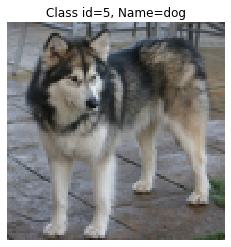

In [10]:
i = random.randint(0, full_train_X.shape[0]-1)
visualize_sample(full_train_X[i],
                 full_train_y[i],
                 full_class_names)

In [11]:
ID_C1_OLD, ID_C2_OLD = 3, 8 # C1: CAT, C2: SHIP
ID_C1_NEW, ID_C2_NEW = 0, 1

In [12]:
def subsplit_two_classes(X, y, split):
    
    indices = np.where(np.logical_or(y==ID_C1_OLD, y==ID_C2_OLD))
    X_out = X[indices]
    y_out = y[indices]
    y_out = (y_out == ID_C1_OLD).astype(np.int) * ID_C1_NEW + (y_out == ID_C2_OLD).astype(np.int) * ID_C2_NEW
    print('Created "{}" subsplit with only 2 classes with sizes: Images {}, labels {}'.format(split, X_out.shape, y_out.shape))
    return X_out, y_out

In [13]:
# make the training and test datasets so that they contain only the two classes of interest
# ===================
train_two_classes_X, train_two_classes_y = subsplit_two_classes(full_train_X,
                                                                full_train_y,
                                                                'train')

test_two_classes_X, test_two_classes_y = subsplit_two_classes(full_test_X,
                                                              full_test_y,
                                                              'test')

class_names_two_classes = [full_class_names[i] for i in (ID_C1_OLD, ID_C2_OLD)]

Created "train" subsplit with only 2 classes with sizes: Images (1000, 3, 96, 96), labels (1000,)
Created "test" subsplit with only 2 classes with sizes: Images (1600, 3, 96, 96), labels (1600,)


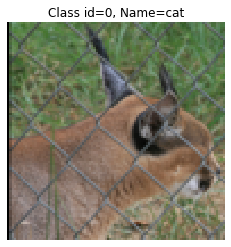

In [14]:
# visualize some examples from the modified datasets
# ===================
i = random.randint(0, train_two_classes_X.shape[0]-1)
visualize_sample(train_two_classes_X[i],
                 train_two_classes_y[i],
                 class_names_two_classes)

In [15]:
# Wrap our dataset into pytorch Dataset class so it can further be used in DataLoader for batch grouping
# ===========================================================================
class ArrayDataset(Dataset):
    
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, index):
        return self.X[index], self.y[index]

In [16]:
 # set the batch size here
 # ===================
BATCH_SIZE = 8

In [17]:
# load the training and test datasets for the two-class classification problem
# https://pytorch.org/docs/stable/data.html
# ===================
loader_two_classes_train = DataLoader(dataset = ArrayDataset(train_two_classes_X, train_two_classes_y),
                                      batch_size=BATCH_SIZE,
                                      shuffle=True,
                                      drop_last=True)

loader_two_classes_test = DataLoader(dataset = ArrayDataset(test_two_classes_X, test_two_classes_y),
                                     batch_size=1,
                                     shuffle=True)

In [18]:
# load the training and test datasets for the ten-class classification problem
# ===================
loader_ten_classes_train = DataLoader(dataset = ArrayDataset(full_train_X, full_train_y),
                                      batch_size=BATCH_SIZE,
                                      shuffle=True,
                                      drop_last=True)

loader_ten_classes_test = DataLoader(dataset = ArrayDataset(full_test_X, full_test_y),
                                     batch_size=1,
                                     shuffle=True)

# Visualizing conv2d

In [20]:
#in_channels (int) – Number of channels in the input image
#out_channels (int) – Number of channels produced by the convolution
c = nn.Conv2d(1,3, stride = 1, kernel_size=(4,5))
print(c.weight.shape)
print(c.weight)

torch.Size([3, 1, 4, 5])
Parameter containing:
tensor([[[[ 0.0092, -0.1381, -0.0719, -0.0076,  0.1190],
          [ 0.1720, -0.1946, -0.1101,  0.2115, -0.2212],
          [ 0.0283,  0.0351,  0.1858, -0.0603,  0.0473],
          [-0.0035, -0.0620,  0.0402,  0.0280, -0.1760]]],


        [[[-0.0296, -0.2129,  0.0887,  0.2022, -0.0725],
          [-0.0981, -0.0175,  0.1162, -0.0584,  0.1994],
          [ 0.1995,  0.0671,  0.0921,  0.1806,  0.2131],
          [-0.2014, -0.2087,  0.0023, -0.1540,  0.2195]]],


        [[[-0.1539, -0.1556, -0.0347,  0.2196,  0.0216],
          [-0.0359, -0.1248, -0.0891,  0.0249, -0.1203],
          [ 0.1774,  0.1649,  0.1858,  0.0135,  0.2040],
          [ 0.0430, -0.1525,  0.1499,  0.1598, -0.1476]]]], requires_grad=True)


## Batch normalization is a technique that can improve the learning rate of a neural network. It does so by minimizing internal covariate shift which is essentially the phenomenon of each layer's input distribution changing as the parameters of the layer above it change during training.

In [24]:
class CNN(nn.Module):
  # ===================
  # the network architecture is defined here
  # documentation of some useful functions:
  #     https://pytorch.org/docs/stable/nn.html#conv2d
  #     https://pytorch.org/docs/stable/nn.html#batchnorm2d
  #     https://pytorch.org/docs/stable/nn.html#maxpool2d
  #     https://pytorch.org/docs/stable/nn.html#linear
  #     https://pytorch.org/docs/stable/nn.html#batchnorm1d
  # ===================
    def __init__(self, num_out_classes):
    
        super(CNN, self).__init__()
        
        num_filters = [3, 6, 12, 24, 64]
    
        # expected size of input to following layer: 3x96x96
        self.conv1 = nn.Conv2d(in_channels=num_filters[0],
                               out_channels=num_filters[1],
                               kernel_size=3,
                               padding=1,
                               bias=False)
        # expected size of input to following layer:
        self.bn1 = nn.BatchNorm2d(num_features=num_filters[1])
        # expected size of input to following layer:
        self.relu1 = nn.ReLU()
        # expected size of input to following layer:
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        # *implement other layers

        self.conv2 = nn.Conv2d(in_channels=num_filters[0],
                               out_channels=num_filters[1],
                               kernel_size=3,
                               padding=1,
                               bias=False)
        self.bn2 = nn.BatchNorm2d(num_features=num_filters[1])
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv3 = nn.Conv2d(in_channels=num_filters[0],
                               out_channels=num_filters[1],
                               kernel_size=3,
                               padding=1,
                               bias=False)
        self.bn3 = nn.BatchNorm2d(num_features=num_filters[1])
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        # function to compute the accuracy of the CNN
# ===========================================================================
def compute_accuracy(data_loader,
                     cnn,
                     split,
                     print_output = True):

    cnn.eval() # sets the model into evaluation mode
    total_accuracy = 0
    total_samples = 0

    for i, batch in enumerate(data_loader):

        # get the inputs and labels
        X_batch, y_batch = batch

        # calculate predictions given a batch of samples
        predictions_batch = cnn(X_batch)

        # convert each prediction into a class id
        _, vals = torch.max(predictions_batch, 1)

        # calculate the amount of predicted class ids matching the ground truth and increment counters
        total_accuracy += (vals == y_batch.type(torch.long)).int().sum()
        total_samples += y_batch.shape[0]

        out_accuracy = int(total_accuracy) * 1.0 / total_samples

    if print_output:
        print('Accuracy over "{}" split is {:02f}%'.format(split, 100 * out_accuracy))

    return 100 * out_accuracy

        # .................

    
    # ===================
    # define the forward pass through the network using the operations defined in the init function
    # ===================
def forward(self, x):
    # bring input to [-1,1] range
    x = x.float() / 128.0 - 1.0
    # sequence of operations: convolution --> batch normalization --> non-linearity --> pooling
    x = self.pool1(self.relu1(self.bn1(self.conv1(x))))
    print('First conv')
    print(x)
    print('First conv')
    # *implement other layers
    x = self.pool2(self.relu2(self.bn2(self.conv2(x))))
    print('Second conv')
    print(x)
    print('Second conv')
    x = self.pool3(self.relu3(self.bn3(self.conv3(x))))
    print('Third conv')
    print(x)
    print('Third conv')
    x = x.view(-1, 24*12*12) # before passing to fully connected layer
    # *implement other layers


    return x


In [27]:
# create an instance of the above defined CNN class
# ===========================================================================
cnn_two_classes = CNN(num_out_classes = 2)

# ===========================================================================
# compute the accuracy of the CNN... we have not yet trained it, so what do you expect the accuracy to be??
# ===========================================================================
compute_accuracy(data_loader = loader_two_classes_train,cnn = cnn_two_classes,split = 'train')


compute_accuracy(data_loader = loader_two_classes_test,cnn = cnn_two_classes,split = 'test')


NotImplementedError: 

In [32]:
def train(cnn,
          loader_train,
          loader_test,
          num_epochs,
          learning_rate = 0.001,
          track_accuracy = False):  
    # ===================
    # define the loss to be minimized
    # https://pytorch.org/docs/stable/nn.html#crossentropyloss
    # ===================
    # *choose loss here
    criterion =nn.CrossEntropyLoss() #loss function
    

    # ===================
    # create an optimizer 
    # You can read more about optimizers here: https://pytorch.org/docs/stable/optim.html
    # You may try with different optimizers and check if that makes any difference
    # For any one optimizer, try changing the learning rate and observe the effect.
    # ===================
    
    # *choose optimizer here
    optimizer = optim.SGD(cnn.parameters(), lr=0.001, momentum=0.9)
    
    # ===================
    # set the model into training mode
    # ===================
    cnn.train() 

    tr_acc = []
    ts_acc = []

    # ===================
    # In each epoch, run the optimizer operation on each batch
    # ===================
    for epoch in range(num_epochs):
            
        epoch_loss = 0.0

        for i, batch in enumerate(loader_train):

            X_batch, y_batch = batch
            y_batch = y_batch.type(torch.long)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward pass
            # *write forward pass
            predictions_batch = cnn(X_batch)
            

            # calculate loss for the provided predictions and ground truth labels
            # =====================================================
            loss = criterion(predictions_batch, y_batch)

            epoch_loss += float(loss)

            # backward pass
            loss.backward()

            # update learnable parameters according to gradients
            optimizer.step()
            
        # ===================
        # track the training and test accuracy.
        # note that this adds quite a bit to the training time,
        # as things are running on the cpu currently.
        # this is usually a good debugging tool to see how the training is progressing
        # and is usually done when people train such networks on gpus.
        # ===================
        if track_accuracy:
            tr_acc.append(compute_accuracy(data_loader = loader_train,
                                           cnn = cnn,
                                           split = 'train',
                                           print_output = False))
            ts_acc.append(compute_accuracy(data_loader = loader_test,
                                           cnn = cnn,
                                           split = 'test',
                                           print_output = False))

        epoch_loss /= len(loader_train)
        print('Epoch {}/{} training loss {:02f}'.format(epoch+1, num_epochs, epoch_loss))

    if track_accuracy:
        plt.figure()
        plt.plot(np.array(tr_acc))
        plt.plot(np.array(ts_acc))
        plt.legend(['training accuracy', 'test accuracy'])
        plt.xlabel('training iterations')
        plt.show()
        plt.close()

    print('Finished Training')



In [33]:
# call the train function and wait for the magic to unfold ;)
# ===========================================================================
train(cnn = cnn_two_classes,
      loader_train = loader_two_classes_train,
      loader_test = loader_two_classes_test,
      num_epochs = 20,
      track_accuracy = True)

NotImplementedError: 

In [ ]:
# Let's reevaluate accuracy now. Did the magic happen?
# ===========================================================================
compute_accuracy(data_loader = loader_two_classes_train,
                 cnn = cnn_two_classes,
                 split = 'train')

compute_accuracy(data_loader = loader_two_classes_test,
                 cnn = cnn_two_classes,
                 split = 'test')

In [ ]:
# create a new instance of the CNN class, to do the classification for all the ten classes
# ===========================================================================
cnn_ten_classes = CNN(num_out_classes = 10)

In [ ]:
# compute the accuracy of the CNN... we have not yet trained it, so what do you expect the accuracy to be??
# ===========================================================================
compute_accuracy(data_loader = loader_ten_classes_train,
                 cnn = cnn_ten_classes,
                 split = 'train')

compute_accuracy(data_loader = loader_ten_classes_test,
                 cnn = cnn_ten_classes,
                 split = 'test')

In [ ]:
# train this new CNN... this will take a while (about 20-30 seconds per epoch)
# ===========================================================================
train(cnn = cnn_ten_classes,
      loader_train = loader_ten_classes_train,
      loader_test = loader_ten_classes_test,
      num_epochs = 10,
      track_accuracy = True)

In [ ]:
# compute the accuracy with the trained CNN...
# ===========================================================================
compute_accuracy(data_loader = loader_ten_classes_train,
                 cnn = cnn_ten_classes,
                 split = 'train')

compute_accuracy(data_loader = loader_ten_classes_test,
                 cnn = cnn_ten_classes,
                 split = 'test')